In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.inspection import permutation_importance

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def naive_roc_auc_score(y_true, y_pred):
  
  y_true = y_true.to_numpy()
  
  num_same_sign = 0
  num_pairs = 0
  
  for a in range(len(y_true)):
    for b in range(len(y_true)):
      if y_true[a] > y_true[b]:
        num_pairs += 1
        if y_pred[a] > y_pred[b]:
          num_same_sign += 1
        elif y_pred[a] == y_pred[b]:
          num_same_sign += .5
        
  return num_same_sign / num_pairs

In [3]:
from sklearn.metrics import make_scorer

score = make_scorer(naive_roc_auc_score, greater_is_better=True)

In [4]:
data = pd.read_csv('NF_Descriptors.csv')
data = data.dropna()
y = data['LUMO_calc']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

Random Forest

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=0)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy versio

Param for GS {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.8842011037987089
Train AUC ROC Score for GS:  0.9401629585723339
Test AUC ROC Score for GS:  0.8864997100160477


Text(0.5, 0, 'Random Forest Feature Importance')

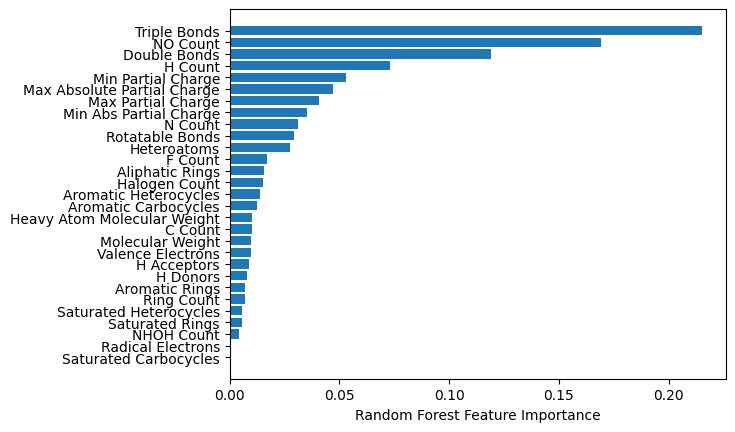

In [6]:
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("LUMO")


In [7]:
# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.15 degrees.


In [8]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Double Bonds0.421 +/- 0.003
Triple Bonds0.335 +/- 0.003
NO Count0.265 +/- 0.002
H Count 0.213 +/- 0.002
Min Partial Charge0.085 +/- 0.001
Rotatable Bonds0.075 +/- 0.001
Max Absolute Partial Charge0.069 +/- 0.001
N Count 0.063 +/- 0.001
Max Partial Charge0.055 +/- 0.001
Min Abs Partial Charge0.047 +/- 0.000
Aliphatic Rings0.035 +/- 0.000
Heteroatoms0.033 +/- 0.000
Aromatic Carbocycles0.026 +/- 0.000
Aromatic Heterocycles0.021 +/- 0.000
F Count 0.019 +/- 0.000
Halogen Count0.016 +/- 0.000
H Donors0.013 +/- 0.001
C Count 0.009 +/- 0.000
H Acceptors0.008 +/- 0.000
Aromatic Rings0.008 +/- 0.000
Valence Electrons0.008 +/- 0.000
Heavy Atom Molecular Weight0.008 +/- 0.000
Saturated Rings0.008 +/- 0.000
Saturated Heterocycles0.007 +/- 0.000
Molecular Weight0.007 +/- 0.000
Ring Count0.007 +/- 0.000
NHOH Count0.004 +/- 0.000


In [9]:
rfr.fit(X_train, y_train)

r = permutation_importance(rfr, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Double Bonds0.376 +/- 0.006
Triple Bonds0.295 +/- 0.006
NO Count0.219 +/- 0.004
H Count 0.167 +/- 0.003
Rotatable Bonds0.063 +/- 0.002
Min Partial Charge0.061 +/- 0.001
N Count 0.045 +/- 0.001
Max Absolute Partial Charge0.043 +/- 0.001
Max Partial Charge0.037 +/- 0.001
Min Abs Partial Charge0.029 +/- 0.001
Aliphatic Rings0.026 +/- 0.001
Heteroatoms0.020 +/- 0.001
Aromatic Carbocycles0.019 +/- 0.001
Aromatic Heterocycles0.015 +/- 0.001
F Count 0.013 +/- 0.001
Halogen Count0.011 +/- 0.000
H Donors0.009 +/- 0.001
Saturated Rings0.006 +/- 0.000
Saturated Heterocycles0.005 +/- 0.000
Aromatic Rings0.004 +/- 0.000
Ring Count0.004 +/- 0.000
H Acceptors0.003 +/- 0.000
NHOH Count0.003 +/- 0.000
C Count 0.003 +/- 0.000
Valence Electrons0.002 +/- 0.000
Heavy Atom Molecular Weight0.001 +/- 0.000
Molecular Weight0.001 +/- 0.000


In [10]:
from sklearn.metrics import mean_squared_error

prediction = rfr.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = rfr.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

R2:  0.8676714975823723
MSE:  0.039383288232546554
RMSE:  0.19845223161392406


In [11]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 105.03 %.


In [12]:
naive_roc_auc_score(y_test, prediction)

0.8861238824387736

In [13]:
data = pd.read_csv('NF_Descriptors.csv')
data = data.dropna()
y = data['HOMO_calc']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=0)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy versio

Param for GS {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.9188619098191367
Train AUC ROC Score for GS:  0.9639239537376936
Test AUC ROC Score for GS:  0.9201418520337326


Text(0.5, 1.0, 'HOMO')

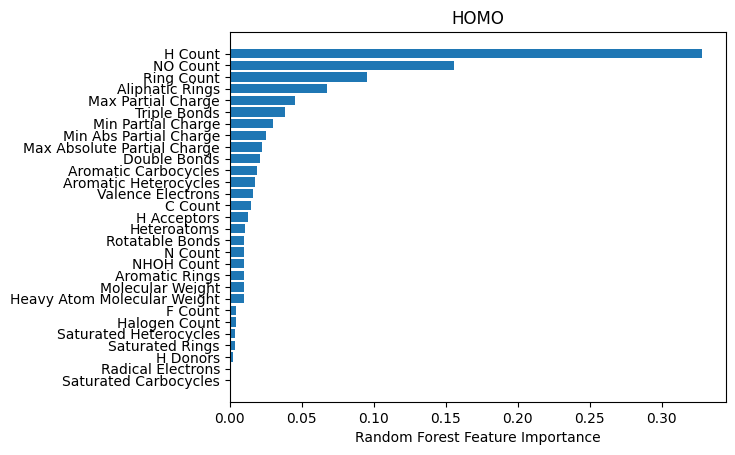

In [22]:
rfr = RandomForestRegressor(random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("HOMO")

In [23]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

H Count 0.616 +/- 0.004
NO Count0.376 +/- 0.005
Aliphatic Rings0.323 +/- 0.004
Ring Count0.211 +/- 0.004
Triple Bonds0.110 +/- 0.002
Max Partial Charge0.085 +/- 0.001
Double Bonds0.055 +/- 0.001
Min Partial Charge0.053 +/- 0.001
Aromatic Carbocycles0.046 +/- 0.001
Aromatic Heterocycles0.044 +/- 0.001
Min Abs Partial Charge0.033 +/- 0.001
Max Absolute Partial Charge0.023 +/- 0.000
C Count 0.023 +/- 0.001
H Acceptors0.022 +/- 0.001
Valence Electrons0.020 +/- 0.000
NHOH Count0.014 +/- 0.000
Aromatic Rings0.012 +/- 0.000
Rotatable Bonds0.011 +/- 0.001
N Count 0.011 +/- 0.000
Heteroatoms0.009 +/- 0.000
Molecular Weight0.009 +/- 0.000
Heavy Atom Molecular Weight0.007 +/- 0.000
Saturated Rings0.005 +/- 0.000
Saturated Heterocycles0.005 +/- 0.000
F Count 0.004 +/- 0.000
Halogen Count0.004 +/- 0.000
H Donors0.002 +/- 0.000


In [24]:
rfr.fit(X_train, y_train)

r = permutation_importance(rfr, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

H Count 0.565 +/- 0.008
NO Count0.343 +/- 0.006
Aliphatic Rings0.288 +/- 0.005
Ring Count0.184 +/- 0.004
Triple Bonds0.102 +/- 0.003
Max Partial Charge0.071 +/- 0.002
Double Bonds0.049 +/- 0.002
Aromatic Carbocycles0.042 +/- 0.001
Aromatic Heterocycles0.034 +/- 0.001
Min Partial Charge0.032 +/- 0.003
Min Abs Partial Charge0.025 +/- 0.002
H Acceptors0.017 +/- 0.001
C Count 0.016 +/- 0.001
Valence Electrons0.015 +/- 0.001
Max Absolute Partial Charge0.014 +/- 0.001
NHOH Count0.014 +/- 0.001
Aromatic Rings0.008 +/- 0.001
N Count 0.008 +/- 0.000
Rotatable Bonds0.007 +/- 0.001
Heteroatoms0.005 +/- 0.000
Saturated Rings0.005 +/- 0.000
Molecular Weight0.004 +/- 0.000
Saturated Heterocycles0.004 +/- 0.000
Heavy Atom Molecular Weight0.003 +/- 0.000
F Count 0.003 +/- 0.000
Halogen Count0.003 +/- 0.000
H Donors0.002 +/- 0.000


In [25]:
# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.12 degrees.


In [26]:
from sklearn.metrics import mean_squared_error

prediction = rfr.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = rfr.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

R2:  0.9159170408246083
MSE:  0.030030103512377584
RMSE:  0.1732919603223923


In [27]:
naive_roc_auc_score(y_test, prediction)

0.920063485897436

BART

In [18]:
with pm.Model() as model_oos_regression:
    X = pm.MutableData("X", X_train)
    Y = y_train
    α = pm.Exponential("α", 1)
    μ = pmb.BART("μ", X, np.log(Y))
    y = pm.NegativeBinomial("y", mu=pm.math.exp(μ), alpha=α, observed=Y, shape=μ.shape)
    idata_oos_regression = pm.sample(random_seed=42)
    posterior_predictive_oos_regression_train = pm.sample_posterior_predictive(
        trace=idata_oos_regression
    )

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'α_log__': array(0.), 'μ': array([nan, nan, nan, ..., nan, nan, nan])}

Logp initial evaluation results:
{'α': -1.0, 'μ': 0.0, 'y': -inf}
You can call `model.debug()` for more details.

In [ ]:
with model_oos_regression:
    X.set_value(X_test)
    posterior_predictive_oos_regression_test = pm.sample_posterior_predictive(
        trace=idata_oos_regression, random_seed=RANDOM_SEED
    )